In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

typeface='Helvetica Neue'
mpl.rcParams['font.weight']=400
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

mpl.rcParams['pdf.fonttype'] = 42

import requests,json,os,imp,re
from io import StringIO
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

bt=imp.load_source("baltic","/Users/evogytis/Documents/baltic/baltic.py") ## baltic available at https://github.com/evogytis/baltic

meta_path='/Users/evogytis/Documents/skeeters/data/CMS001_CMS002_MergedAnnotations_190325.csv'
metadata={}
for line in open(meta_path,'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
        print(header)
    else:
        metadata[l[0]]={header[i]:l[i] for i in range(len(l))} ## load metadata

['NewIDseqName', 'OldIDseqName', 'czbiohub-mosquito_sequences_id', 'raw_sequence_run_directory', 'host', 'sample_type', 'nucleotide_type', 'collection_date', 'collection_lat', 'collection_long', 'Habitat', 'Population', 'collected_by', 'preservation_method', 'sex', 'life_stage', 'visual_genus', 'visual_species', 'compute_genus', 'compute_species', 'blood_fed', 'sample_unit', 'known_organism', 'detection_method', 'library_prep', 'sequencer', 'rna_dna_input_ng', 'library_prep_batch', 'extraction_batch', 'Notes:']


In [2]:
labels={
        'Mononega_22_RdRp_CulexMononegaLike2.newick':'Borna- and Nyamivirus-like\n(Mononegavirales)',
        'VirgaLike_group_RdRp.newick':'Virga- and Negev-like viruses\n(Hepe-Virga group)',
        'Orthomyxo_77_18_PB1s.newick':'Quaranjavirus\n(Orthomyxoviridae)',
        'Narna_5_RdRp.newick':'Narnavirus\n(Narnaviridae)',
        'SobemoLike_17_RdRp.newick':'Sobemoviridae',
        'PartitiLike_17_RdRp.newick':'Partitiviridae'
       } ## names for each phylogeny


highlights={'Mononega_22_RdRp_CulexMononegaLike2.newick':['MF176332|Culex mononega-like virus 2|Culex quinquefasciatus|19-Aug-2015', 'MF176356|Culex mononega-like virus 1|Culex globocoxitus|19-Aug-2015', 'MH237595|Aedes aegypti anphevirus|Aedes aegypti|14-Sep-2016', 'KX884428|Hubei rhabdo-like virus 7|Odonata|2013', 'KX148553|Gambie virus|Anopheles sp.|2012', 'KM817638|Shuangao Fly Virus 2|Psychoda alternata|2013'],
            'VirgaLike_group_RdRp.newick':['KX883772|Hubei virga-like virus 2|mosquitoes|2013', 'MH634502|Culex pipiens associated Tunisia virus|Anopheles epiroticus|23-Jan-2014', 'KX518776|Negev virus|Culex quinquefasciatus|2014', 'KX883792|Hubei virga-like virus 9|Diptera|2013', 'MH614306|Mill Lade virus|Bombus sp.|2009/2011', 'KX966285|Adelphocoris suturalis virus||Jul-2015', 'KU754516|Buckhurst virus|Drosophila obscura|2011'],
            'Orthomyxo_77_18_PB1s.newick':['KX898491|Whidbey virus', 'KM817622|Wuhan Mosquito Virus 3', 'FJ861697|Johnston Atoll quaranjavirus', 'LC010982|Thogoto thogotovirus', 'NC_036615|Influenza D virus D/swine/Oklahoma/1334/2011|swine|21-Mar-2011', 'AF262392|Salmon isavirus', 'KX883843|Beihai orthomyxo-like virus 2', 'KX883868|Hubei orthomyxo-like virus 2', 'MF190045|Barns Ness dog whelk orthomyxo-like virus 1', 'KM817628|Wuchang Cockroach Virus 2', 'KM817623|Wuhan Mosquito Virus 4|Culex tritaeniorhynchus|2013'],
            'Narna_5_RdRp.newick':['KP642120|Narnaviridae environmental sample', 'MF190030|Barns Ness breadcrumb sponge narna-like virus 4', 'KX883461|Zhejiang mosquito virus 3', 'KX883539|Hubei narna-like virus 21', 'MH213236|Linepithema humile narna-like virus 1', 'KX883577|narna-like virus 6', 'LC150604|Fusarium poae narnavirus 1', 'MG967346|Blechomonas maslovi narnavirus 1'],
            'SobemoLike_17_RdRp.newick':['MK285337|Renna virus|Aedes aegypti|2016', 'KX882764|Hubei mosquito virus 2|mosquitoes|2013', 'MF189986|Caledonia beadlet anemone sobemo-like virus 1|Actinia equina|2014', 'MF176386|Culex luteo-like virus|Culex australicus|19-Aug-2015', 'MF893258|Tama virus|Drosophila suzukii|May-2016', 'MF893251|Medway virus|Drosophila suzukii|Sep-2014', 'KX138223|Baird Spence virus|Argentine ant|13-Apr-2016'],
            'PartitiLike_17_RdRp.newick':['MH384299|Galbut virus|Drosophila melanogaster|2008', 'KX884104|Hubei partiti-like virus 22|mosquitoes|2013', 'KF372436|Rhizoctonia solani dsRNA virus 2|Rhizoctonia solani AG-1 IA strain GD11|Jul-1996', 'KX884179|Sanxia partiti-like virus 1|water striders|2013', 'KX884148|Hubei partiti-like virus 38|Diptera|2013', 'KX148575|Partitivirus-like 1|Anopheles gambiae|2013', 'MF176260|Wilkie partiti-like virus 2||07-Sep-2015', 'MK292286|Medicago sativa alphapartitivirus 1|Medicago sativa|11-Sep-2011', 'MH188050|Partitivirus-like Culex mosquito virus|Culex sp. mosquito|02-Jul-2016', 'KT598244|Soybean leaf-associated partitivirus 2||15-Aug-2008']
            } ## pick which tips to highlight

trees={} ## will contain tree objects

for path,dirs,fnames in os.walk('/Users/evogytis/Dropbox/Jupyter_notebooks/Biohub/California_mosquitoes/trees/wide/'): ## walk through directory with trees
    for fname in fnames:
        if 'newick' in fname: ## if newick file
            print(fname)
            ll=bt.loadNewick(os.path.join(path,fname)) ## load tree
            ll.treeStats()
            ll.drawUnrooted() ## compute unrooted coordinates
            trees[fname]=ll
            
            print('missing highlights:',[x for x in highlights[fname] if [x in w.numName for w in ll.getExternal()].count(True)==0]) ## check if tips designated for highlighting are missing from tree

Mononega_22_RdRp_CulexMononegaLike2.newick

Tree height: 3.974657
Tree length: 16.891349
strictly bifurcating tree

Numbers of objects in tree: 101 (51 nodes and 50 leaves)

missing highlights: []
Orthomyxo_77_18_PB1s.newick

Tree height: 5.566384
Tree length: 42.819147
strictly bifurcating tree

Numbers of objects in tree: 197 (99 nodes and 98 leaves)

missing highlights: []
VirgaLike_group_RdRp.newick

Tree height: 4.268315
Tree length: 66.571369
strictly bifurcating tree

Numbers of objects in tree: 193 (97 nodes and 96 leaves)

missing highlights: []
Narna_5_RdRp.newick

Tree height: 6.126546
Tree length: 51.237635
strictly bifurcating tree

Numbers of objects in tree: 159 (80 nodes and 79 leaves)

missing highlights: []
SobemoLike_17_RdRp.newick

Tree height: 3.637537
Tree length: 17.771792
strictly bifurcating tree

Numbers of objects in tree: 207 (104 nodes and 103 leaves)

missing highlights: []
PartitiLike_17_RdRp.newick

Tree height: 3.187740
Tree length: 78.779334
strictly b

6
['MF176332|Culex mononega-like virus 2|Culex quinquefasciatus|19-Aug-2015', 'MF176356|Culex mononega-like virus 1|Culex globocoxitus|19-Aug-2015', 'MH237595|Aedes aegypti anphevirus|Aedes aegypti|14-Sep-2016', 'KX884428|Hubei rhabdo-like virus 7|Odonata|2013', 'KX148553|Gambie virus|Anopheles sp.|2012', 'KM817638|Shuangao Fly Virus 2|Psychoda alternata|2013']
['KX898491|Whidbey virus', 'KM817622|Wuhan Mosquito Virus 3', 'FJ861697|Johnston Atoll quaranjavirus', 'LC010982|Thogoto thogotovirus', 'NC_036615|Influenza D virus D/swine/Oklahoma/1334/2011|swine|21-Mar-2011', 'AF262392|Salmon isavirus', 'KX883843|Beihai orthomyxo-like virus 2', 'KX883868|Hubei orthomyxo-like virus 2', 'MF190045|Barns Ness dog whelk orthomyxo-like virus 1', 'KM817628|Wuchang Cockroach Virus 2', 'KM817623|Wuhan Mosquito Virus 4|Culex tritaeniorhynchus|2013']
['KX883772|Hubei virga-like virus 2|mosquitoes|2013', 'MH634502|Culex pipiens associated Tunisia virus|Anopheles epiroticus|23-Jan-2014', 'KX518776|Negev v

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


[-3.871932962834442, 1.5408686281114532, -3.269199866582156, 2.4062584466831964, -3.96315846162362, 3.3484899263103634, -2.6579145180170816, 4.436606292979592, -1.8002856183095954, 1.615677946045644, -2.601253068513461, 1.9701224651560791] [-1.4310715149689712, 0.8264394282573857, -2.7258739883404703, 3.437710400600112, -3.8168926451883314, 2.9695387569462746, -2.6622782019953535, 5.092637491791198, -2.2196758181372607, 1.6907753949777578, -2.8611791979984202, 3.347811283739113]


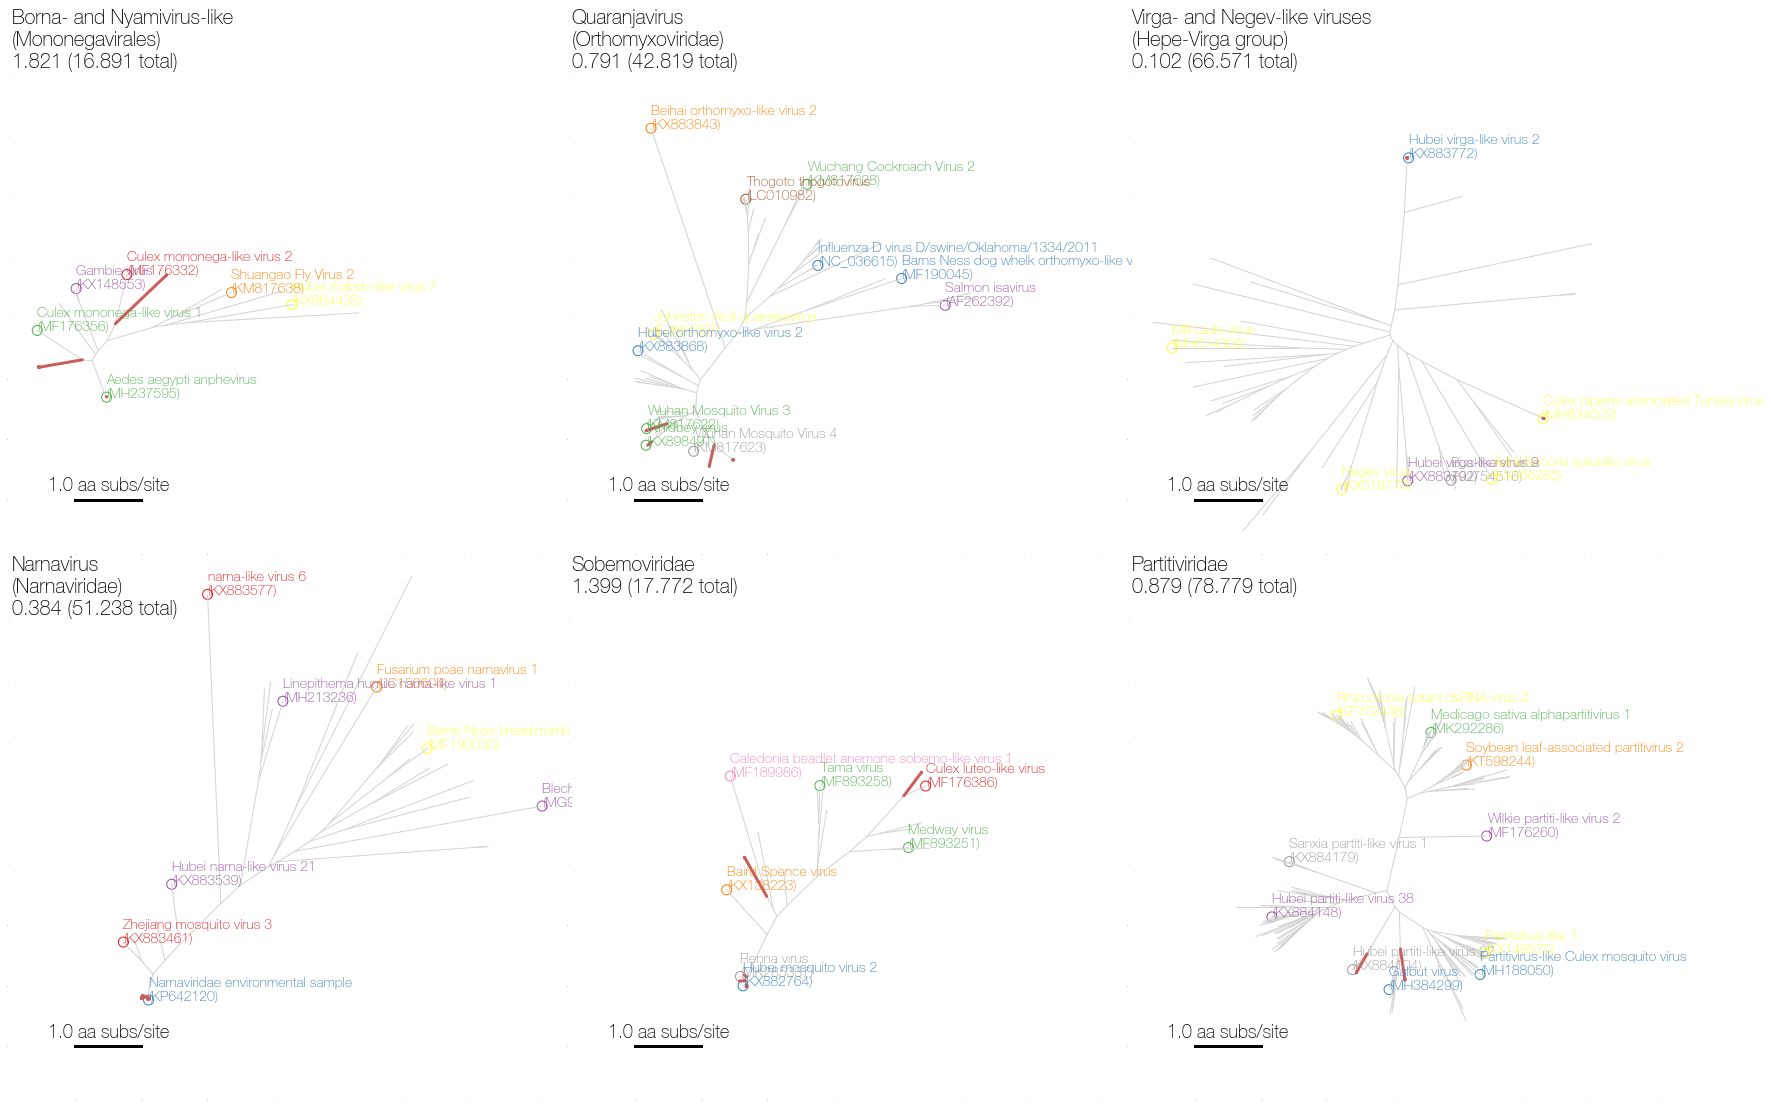

In [3]:
print(len(trees))
cols=3
fig = plt.figure(figsize=(30, 20),facecolor='w') 
gs = gridspec.GridSpec(int(len(trees)/cols),cols,wspace=0.01,hspace=0.01) 

xlims=[] ## will keep track of maximum range of coordinates of all plots
ylims=[]

contigs=lambda k: k.numName.split('|')[1].startswith('CMS00') ## all contigs from study begin with 'CMS'
background=lambda k: k.numName.split('|')[1].startswith('CMS00')==False

for t,tr in enumerate(trees):
    ax=plt.subplot(gs[t],facecolor='w') ## new subplot
    ll=trees[tr] ## get tree
    
    for k in ll.getExternal(background): ## iterate through tips that are background
        cur_node=k
        while cur_node: ## descend from each background tip, mark its path as "background"
            cur_node.traits['background']=True
            cur_node=cur_node.parent
            
    print(highlights[tr])
    
    for k in ll.Objects: ## iterate through all branches
        x,y=k.x,k.y
        xp,yp=k.parent.x,k.parent.y
        if 'background' in k.traits: ## if branch is designated as background - change colour
            c='lightgrey'
            z=1
            lw=1
            ls='-'
        else:
            c='indianred'
            z=2
            lw=3
            ls='-'   
        ax.plot([xp,x],[yp,y],color=c,lw=lw,zorder=z,ls=ls,solid_capstyle='round') ## plot branch
        
        if k.branchType=='leaf' and [x in k.numName for x in highlights[tr]].count(True)>0: ## tip which is a designated highlight
            randomColour=mpl.cm.Set1(np.random.random()) ## fetch random colour
            ax.text(x,y,'%s\n(%s)'%(k.numName.split('|')[1],k.numName.split('|')[0]),size=14,color=randomColour,clip_on=False) ## add text for tip
            ax.scatter(x,y,s=100,facecolor='none',edgecolor=randomColour) ## mark tip with circle
        
    contig_lengths=sum(ll.getParameter('length',use_trait=False,which_branches=lambda k: 'background' not in k.traits)) ## get all branch lengths that aren't designated as background
    all_lengths=sum(ll.getParameter('length',use_trait=False)) ## get all branch lengths
    
    xlims+=ax.get_xlim() ## remember plot limits
    ylims+=ax.get_ylim()
    
    barLength=1.0
    start=-3
    ax.plot([start,start+barLength],[-3.0,-3.0],lw=3,color='k') ## add scale bar for branch length
    ax.text(start+barLength/2.0,-2.9,'%s aa subs/site'%(barLength),ha='center',va='bottom',weight=400,size=18,color='k')
    
    ax.text(0,1,'%s\n%.3f (%.3f total)'%(labels[tr],contig_lengths,all_lengths),size=20,ha='left',va='top',clip_on=False,transform=ax.transAxes) ## add text for which tree it is and branch lengths
    
    [ax.spines[loc].set_visible(False) for loc in ax.spines] ## remove plot spines
    ax.tick_params(size=0,labelsize=0) ## no labels
    
for t in range(len(trees)): ## iterate again through trees
    ax=plt.subplot(gs[t],facecolor='w') ## get axis limits
    ax.set_xlim(min(xlims),max(xlims)) ## set the same limits to every plot
    ax.set_ylim(min(ylims),max(ylims))
print(xlims,ylims)

plt.savefig('/Users/evogytis/Downloads/skeeters_contributions.pdf',bbox_inches='tight',dpi=300) ## save figure as PDF for further editing
plt.show()